```{currentmodule} tskit
```

In [1]:
import msprime
import numpy as np
import tskit

def ld():
    ts = msprime.simulate(100, recombination_rate=10, mutation_rate=20, random_seed=1)
    ts.dump("data/ld.trees")

def ld_threads():
    ts = msprime.simulate(500, Ne=1e4, length=1e6, recombination_rate=2e-8, mutation_rate=2e-8)
    ts.dump("data/ld_threads.trees")

def create_notebook_data():
    computing_statistics()
    afs()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_parallelization)=

# _Parallelized analysis_
% remove underscores in title when tutorial is complete or near-complete

:::{note}
This is a draft tutorial which currently uses the somewhat old {class}`LdCalculator`
framework to illustrate how to run tree sequence analyses in parallel. We intend to
update the example to use a more up-to-date analytical tool.
:::


## Calculating LD

The {class}`LdCalculator` class allows us to compute pairwise 
[linkage disequilibrium](https://en.wikipedia.org/wiki/Linkage_disequilibrium) coefficients.
Here we use the {meth}`tskit.LdCalculator.r2_matrix` method to easily make an
LD plot using [matplotlib](http://matplotlib.org/). (Thanks to
the excellent [scikit-allel](http://scikit-allel.readthedocs.io/en/latest/index.html)
for the basic
[plotting code](http://scikit-allel.readthedocs.io/en/latest/_modules/allel/stats/ld.html#plot_pairwise_ld)
used here.)

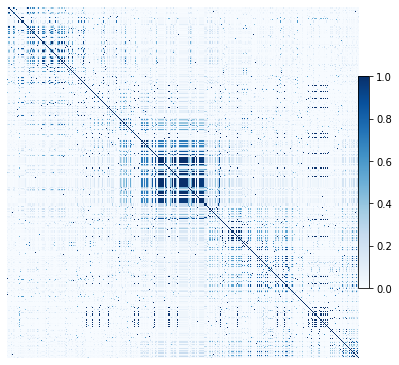

In [2]:
import tskit
import matplotlib.pyplot as plt

ts = tskit.load("data/ld.trees")
ld_calc = tskit.LdCalculator(ts)
A = ld_calc.r2_matrix()
# Now plot this matrix.
x = A.shape[0] / plt.rcParams["figure.dpi"]
x = max(x, plt.rcParams["figure.figsize"][0])
fig, ax = plt.subplots(figsize=(x, x))
fig.tight_layout(pad=0)
im = ax.imshow(A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
ax.set_xticks([])
ax.set_yticks([])
for s in "top", "bottom", "left", "right":
    ax.spines[s].set_visible(False)
plt.gcf().colorbar(im, shrink=0.5, pad=0)
plt.show()

(sec_tutorial_threads)=

## Working with threads

When performing large calculations it's often useful to split the
work over multiple processes or threads. The ``tskit`` API can
be used without issues across multiple processes, and the Python
{mod}`multiprocessing` module often provides a very effective way to
work with many replicate simulations in parallel.

When we wish to work with a single very large dataset, however, threads can
offer better resource usage because of the shared memory space. The Python
{mod}`threading` library gives a very simple interface to lightweight CPU
threads and allows us to perform several CPU intensive tasks in parallel. The
``tskit`` API is designed to allow multiple threads to work in parallel when
CPU intensive tasks are being undertaken.

:::{note}
In the CPython implementation the 
[Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock) ensures that
only one thread executes Python bytecode at one time. This means that
Python code does not parallelise well across threads, but avoids a large
number of nasty pitfalls associated with multiple threads updating
data structures in parallel. Native C extensions like ``numpy`` and ``tskit``
release the GIL while expensive tasks are being performed, therefore
allowing these calculations to proceed in parallel.
:::


In the following example we wish to find all mutations that are in approximate
LD ({math}`r^2 \geq 0.5`) with a given set of mutations. We parallelise this
by splitting the input array between a number of threads, and use the
{meth}`LdCalculator.r2_array` method to compute the {math}`r^2` value
both up and downstream of each focal mutation, filter out those that
exceed our threshold, and store the results in a dictionary. We also
use the very cool [tqdm](https://pypi.python.org/pypi/tqdm) module to give us a
progress bar on this computation.

In [3]:
import threading
import numpy as np
from tqdm.notebook import tqdm  # if not in a jupyter notebook use `from tqdm import tqdm`
import msprime
import tskit
import math


def find_ld_sites(
    tree_sequence, focal_mutations, max_distance=1e6, r2_threshold=0.5, num_threads=8
):
    results = {}
    progress_bar = tqdm(total=len(focal_mutations))
    num_threads = min(num_threads, len(focal_mutations))

    def thread_worker(thread_index):
        ld_calc = tskit.LdCalculator(tree_sequence)
        chunk_size = int(math.ceil(len(focal_mutations) / num_threads))
        start = thread_index * chunk_size
        for focal_mutation in focal_mutations[start : start + chunk_size]:
            a = ld_calc.r2_array(
                focal_mutation, max_distance=max_distance, direction=tskit.REVERSE
            )
            rev_indexes = focal_mutation - np.nonzero(a >= r2_threshold)[0] - 1
            a = ld_calc.r2_array(
                focal_mutation, max_distance=max_distance, direction=tskit.FORWARD
            )
            fwd_indexes = focal_mutation + np.nonzero(a >= r2_threshold)[0] + 1
            indexes = np.concatenate((rev_indexes[::-1], fwd_indexes))
            results[focal_mutation] = indexes
            progress_bar.update()

    threads = [
        threading.Thread(target=thread_worker, args=(j,)) for j in range(num_threads)
    ]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    progress_bar.close()
    return results

ts = tskit.load("data/ld_threads.trees")
counts = np.zeros(ts.num_sites)
for tree in ts.trees():
    for site in tree.sites():
        assert len(site.mutations) == 1
        mutation = site.mutations[0]
        counts[site.id] = tree.num_samples(mutation.node)
doubletons = np.nonzero(counts == 2)[0]
results = find_ld_sites(ts, doubletons, num_threads=8)
print("Found LD sites for", len(results), "doubleton sites out of", ts.num_sites)

  0%|          | 0/4010 [00:00<?, ?it/s]

Found LD sites for 4010 doubleton sites out of 60721


In this example, we first load a simulation of 1000 samples of 10 megabases and find all
doubleton mutations in the resulting tree sequence. We then call the
``find_ld_sites()`` function to find all mutations that are within 1 megabase
of these doubletons and have an {math}`r^2` statistic of greater than 0.5.

The ``find_ld_sites()`` function performs these calculations in parallel using
8 threads. The real work is done in the nested ``thread_worker()`` function,
which is called once by each thread. In the thread worker, we first allocate an
instance of the {class}`LdCalculator` class. (It is **critically important**
that each thread has its own instance of {class}`LdCalculator`, as the threads
will not work efficiently otherwise.) After this, each thread works out the
slice of the input array that it is responsible for, and then iterates over
each focal mutation in turn. After the {math}`r^2` values have been calculated,
we then find the indexes of the mutations corresponding to values greater than
0.5 using {func}`numpy.nonzero`. Finally, the thread stores the resulting array
of mutation indexes in the ``results`` dictionary, and moves on to the next
focal mutation.